<a href="https://colab.research.google.com/github/AaryaPakhale/Intern_Task2/blob/main/Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [ ]:
!pip install autils

In [ ]:
!pip install wordcloud


In [ ]:
#import relevant libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt
import pandas as pd
from autils import *
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download kazanova/sentiment140
!unzip sentiment140.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

LOADING DATA AND ADDING INDICES

In [ ]:
#load dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [ ]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
headers = df.columns
headers

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
df['target'] = df['target'].replace(4,1)

CLEANING DATA

In [ ]:
#cleaning the text
import string
import re

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
print(df['text'].head())

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
print(df['text'].tail())

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
print(df['text'].tail())

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
print(df['text'].tail())

def cleaning_uppercase(text):
  return text.lower()
df['text'] = df['text'].apply(lambda x: cleaning_uppercase(x))
print(df['text'].tail())

def cleaning_punctuations(text):
    punctuations = string.punctuation + "¡" + "¿"
    no_punc_sentence = text.translate(str.maketrans('', '', punctuations))
    return no_punc_sentence
df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))
print(df['text'].tail())


0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    upset can't update Facebook texting it... migh...
2    @Kenichan I dived many times ball. Managed sav...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object
1599995     Just woke up. Having no school best feeling ever
1599996    TheWDB.com - Very cool hear old Walt interview...
1599997                 Are ready MoJo Makeover? Ask details
1599998    Happy 38th Birthday boo alll time!!! Tupac Ama...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object
1599995     Just woke up. Having no school best feeling ever
1599996    TheWDB.com - Very cool hear old Walt interview...
1599997                 Are ready MoJo Makeover? Ask details
1599998    Happy 38th Birthday boo alll time!!! Tupac Ama...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object
1599995     Just woke up. Having no s

In [ ]:
from keras.preprocessing import sequence
from keras.datasets.imdb import get_word_index

# tokenizing text
word_index=get_word_index()
MAXLEN= 250


def tokenize_text(text):
    tokens=tf.keras.preprocessing.text.text_to_word_sequence(text)
    tokens=[word_index[word] if word in word_index else 0 for word in tokens]
    return sequence.pad_sequences([tokens], MAXLEN)[0]


In [ ]:
new_df = df.drop_duplicates()
new_df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

DATA VISUALIZATION

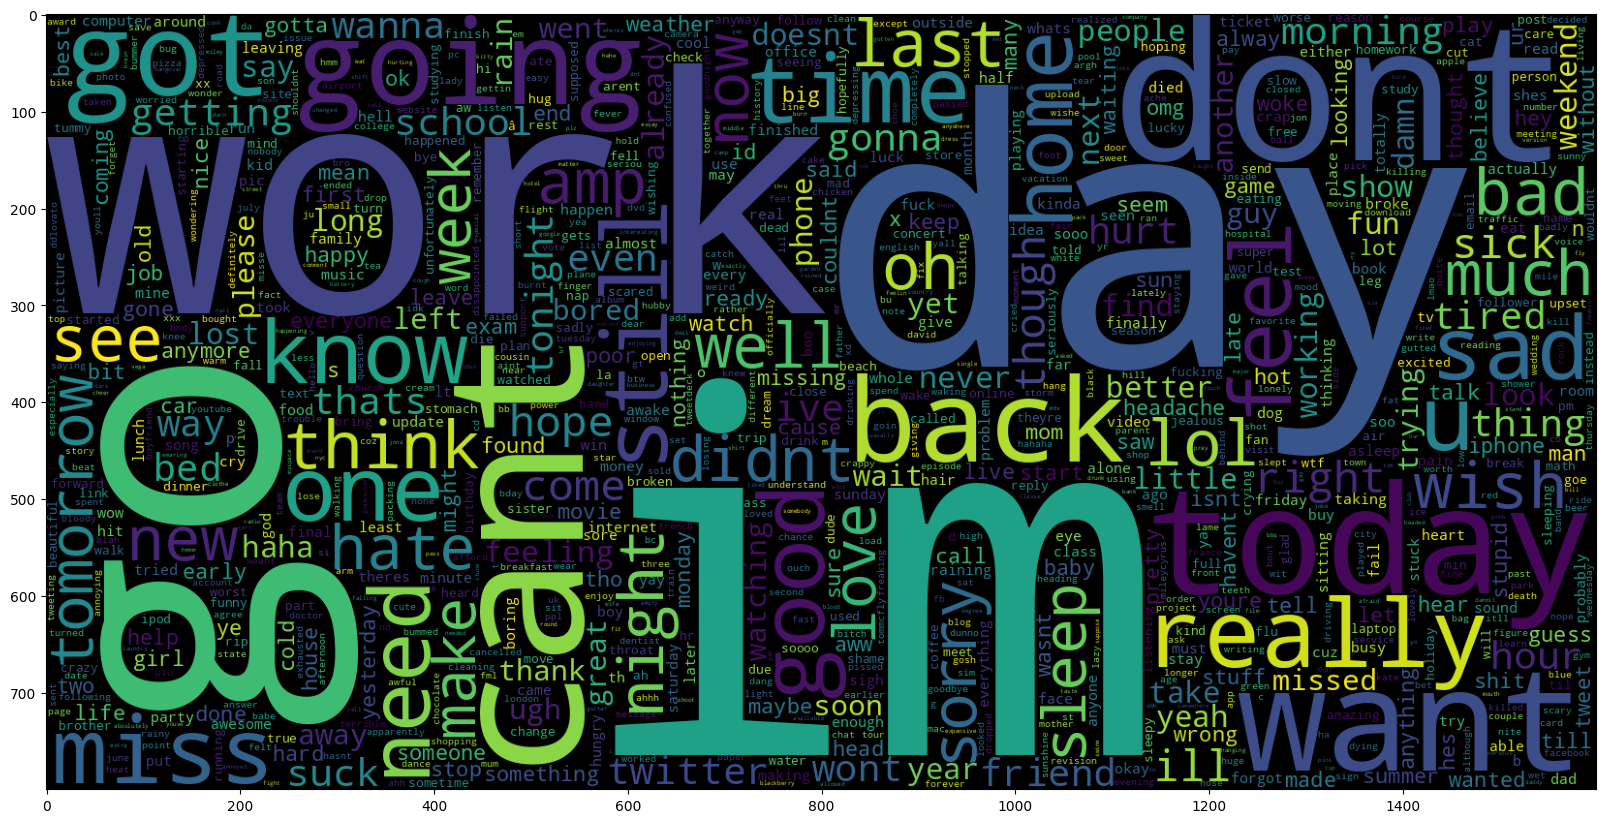

In [ ]:
#plotting wordcloud for negative
import wordcloud
import matplotlib.pyplot as plt  # Import matplotlib.pyplot explicitly

X = df.text
y = df.target
data_neg = df['text'][:800000]

plt.figure(figsize=(20, 20))

wc = wordcloud.WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))

plt.imshow(wc)
plt.show()

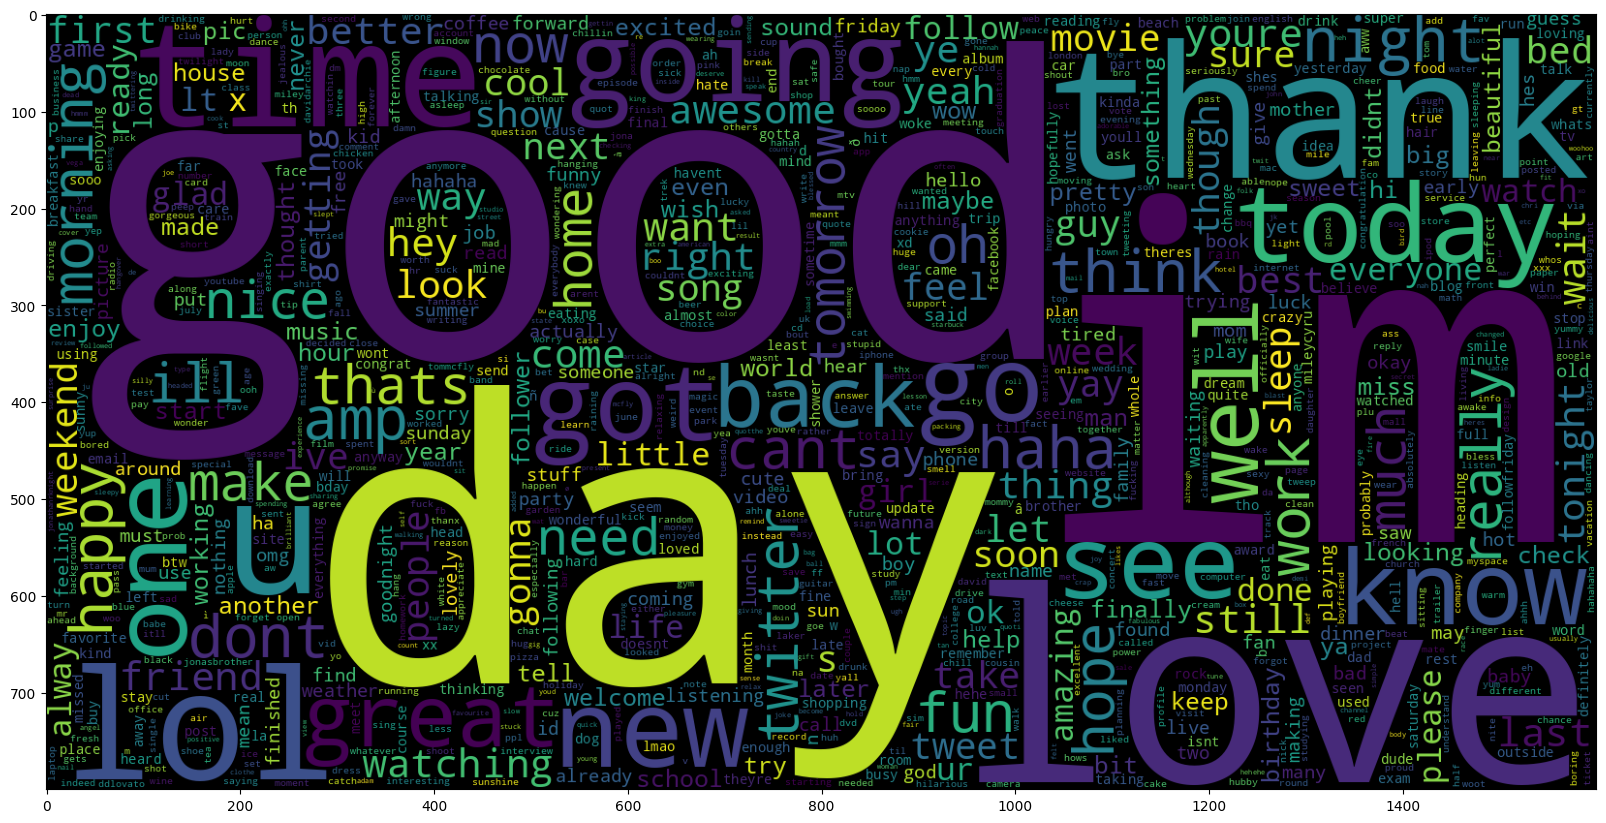

In [ ]:
#plotting wordcloud for positive
import wordcloud
import matplotlib.pyplot as plt

X = df.text
y = df.target
data_pos = df['text'][800000:]

plt.figure(figsize=(20, 20))

wc = wordcloud.WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_pos))

plt.imshow(wc)
plt.show()

<Axes: xlabel='target', ylabel='count'>

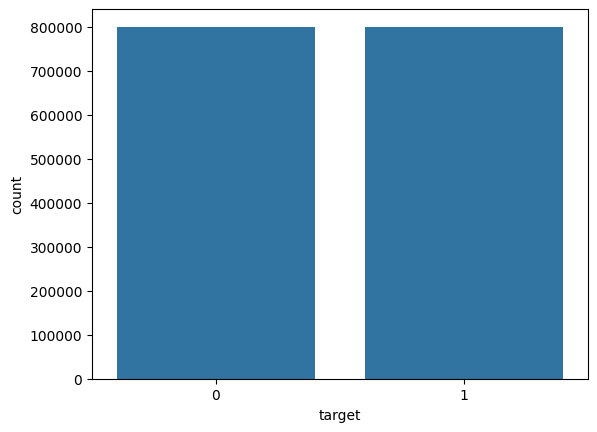

In [ ]:
#countplot for target data
import seaborn as sns
sns.countplot(x='target', data=df)


Statistics of text lengths:
count    1.600000e+06
mean     5.213785e+01
std      2.659128e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.800000e+01
75%      7.200000e+01
max      3.520000e+02
Name: text_length, dtype: float64


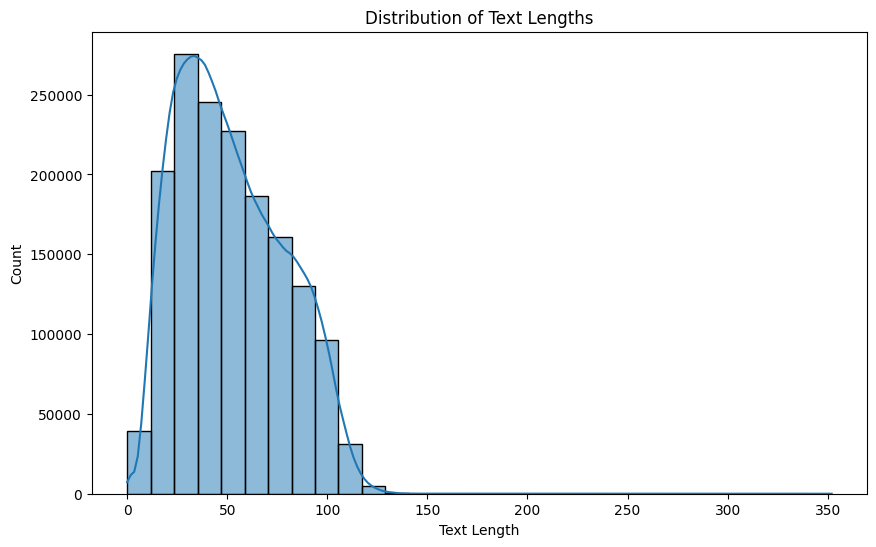

In [ ]:
#plotting histogram of text length

df['text_length'] = df['text'].apply(len)
print("\nStatistics of text lengths:")
print(df['text_length'].describe())


plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

<ipython-input-100-e8c26f18f9d7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='Set1')


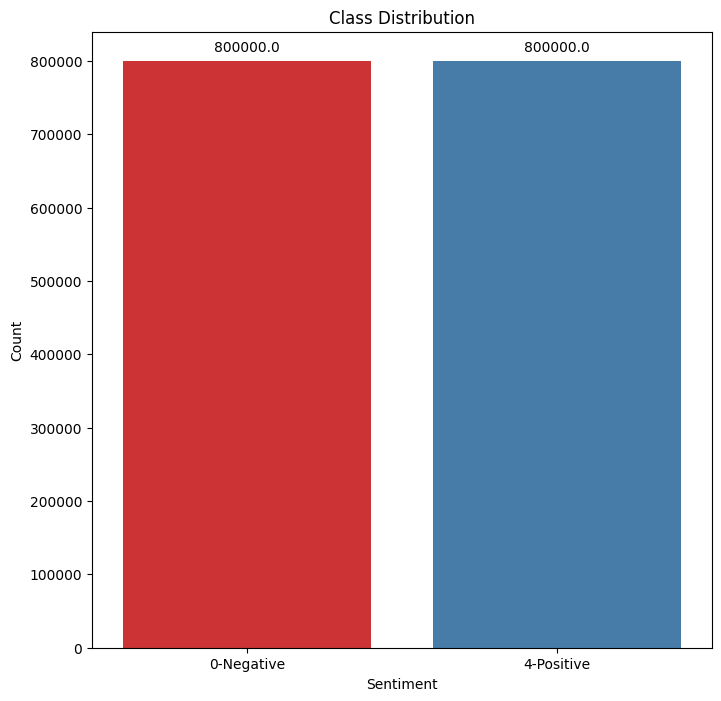

In [ ]:
#plotting countplot
plt.figure(figsize=(8, 8))
ax = sns.countplot(x='target', data=df, palette='Set1')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0-Negative', '4-Positive'])  # Set custom x-axis labels
#
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

TEST-TRAIN SPLIT

In [ ]:
#test_train split
_, df = train_test_split(df, test_size=0.05, random_state=42)
train_data, test_data = train_test_split(df, test_size=0.5, random_state=42)

In [ ]:
#encoding data from the dataset
from tqdm import tqdm
for x in tqdm(range(len(train_data))):
  train_data.text.iloc[x]=tokenize_text(train_data.text.iloc[x])
for x in tqdm(range(len(test_data.text))):
  test_data.text.iloc[x]=tokenize_text(test_data.text.iloc[x])

train_labels = train_data.target
train_text=sequence.pad_sequences(train_data.text, MAXLEN)

test_labels = test_data.target
test_text=sequence.pad_sequences(test_data.text, MAXLEN)

  0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-102-f04d8f5b807b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.text.iloc[x]=tokenize_text(train_data.text.iloc[x])
  0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-102-f04d8f5b807b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.text.iloc[x]=tokenize_text(test_data.text.iloc[x])
100%|██████████| 40000/40000 [00:50<00:00, 798.43it/s]


ML MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

# Define parameters
sequence_length = 250  # Maximum tweet length
embedding_dim = 100  # Dimension of word embeddings
vocab_size = 50000  # Number of unique words
lstm_units = 128  # Number of LSTM units

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
model.add(LSTM(lstm_units))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile and train the model
from keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model.fit(train_text, train_labels, epochs=20, batch_size=32,verbose=1, callbacks=[early_stopping])

Epoch 1/20
1250/1250 [==============================] - 34s 25ms/step - loss: 0.5292 - accuracy: 0.7348
Epoch 2/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.4181 - accuracy: 0.8048
Epoch 3/20
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3452 - accuracy: 0.8452
Epoch 4/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.2835 - accuracy: 0.8736
Epoch 5/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2353 - accuracy: 0.8978
Epoch 6/20
1250/1250 [==============================] - 17s 14ms/step - loss: 0.1952 - accuracy: 0.9152
Epoch 7/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.1634 - accuracy: 0.9303
Epoch 8/20
1250/1250 [==============================] - 19s 16ms/step - loss: 0.1396 - accuracy: 0.9389
Epoch 9/20
1250/1250 [==============================] - 20s 16ms/step - loss: 0.1214 - accuracy: 0.9481
Epoch 10/20
1250/1250 [==============================] - 22s 18m

In [ ]:
model.evaluate(test_text, test_labels)


1250/1250 [==============================] - 8s 6ms/step - loss: 2.2610 - accuracy: 0.7187


[2.2610273361206055, 0.7187250256538391]